<a href="https://colab.research.google.com/github/Lb350/ML_real_fake_news_detect/blob/main/PW_10_1_%D0%9E%D0%B1%D0%BD%D0%B0%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5_%D1%84%D0%B0%D0%BB%D1%8C%D1%88%D0%B8%D0%B2%D1%8B%D1%85_%D0%BD%D0%BE%D0%B2%D0%BE%D1%81%D1%82%D0%B5%D0%B9_Kravchenko.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Импортируем необходимые библиотеки*

In [63]:
import os
from requests import get
import numpy as np
import pandas as pd
import itertools
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import sklearn.metrics as sk_metrics
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier

import seaborn as sns


*Подгружаем датасет*

In [64]:
response = get('https://storage.yandexcloud.net/academy.ai/practica/fake_news.csv')

with open('fake_news.csv', 'wb') as f:
  f.write(response.content)

FILE_PATH = './'
os.listdir(FILE_PATH)
df = pd.read_csv(f'{FILE_PATH}fake_news.csv')

*Изучаем датасет*

In [65]:
df.shape

(6335, 4)

In [66]:
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [67]:
df.tail()

,Unnamed: 0,title,text,label
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL
6334,4330,Jeb Bush Is Suddenly Attacking Trump. Here's W...,Jeb Bush Is Suddenly Attacking Trump. Here's W...,REAL


*Проверка нулевых значений*

In [68]:
df.isnull().sum()

,0
Unnamed: 0,0
title,0
text,0
label,0


*Приведение датасета*

In [69]:
df.label

,label
0,FAKE
1,FAKE
2,REAL
3,FAKE
4,REAL
...,...
6330,REAL
6331,FAKE
6332,FAKE
6333,REAL


In [70]:
i = df.label.value_counts()
print(i)

label
REAL    3171
FAKE    3164
Name: count, dtype: int64


In [71]:
fig = go.Figure(data=[go.Bar(
    x=['Real', 'Fake'],
    y=i,
    text=i,
    textposition='auto',
)])

fig.show()

*Разделяем датасет на обучающий и тестовый*

In [72]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df.label, test_size=0.2, random_state=7)

In [73]:
print('X_train:\n',X_train)
print('y_train:\n',y_train)

X_train:
 6237    The head of a leading survivalist group has ma...
3722    ‹ › Arnaldo Rodgers is a trained and educated ...
5774    Patty Sanchez, 51, used to eat 13,000 calories...
336     But Benjamin Netanyahu’s reelection was regard...
3622    John Kasich was killing it with these Iowa vot...
                              ...                        
5699                                                     
2550    It’s not that Americans won’t elect wealthy pr...
537     Anyone writing sentences like ‘nevertheless fu...
1220    More Catholics are in Congress than ever befor...
4271    It was hosted by CNN, and the presentation was...
Name: text, Length: 5068, dtype: object
y_train:
 6237    FAKE
3722    FAKE
5774    FAKE
336     REAL
3622    REAL
        ... 
5699    FAKE
2550    REAL
537     REAL
1220    REAL
4271    REAL
Name: label, Length: 5068, dtype: object


In [74]:
print('X_test:\n',X_test)
print('y_test:\n',y_test)

X_test:
 3534    A day after the candidates squared off in a fi...
6265    VIDEO : FBI SOURCES SAY INDICTMENT LIKELY FOR ...
3123    It's debate season, where social media has bro...
3940    Mitch McConnell has decided to wager the Repub...
2856    Donald Trump, the actual Republican candidate ...
                              ...                        
4986    Washington (CNN) President Barack Obama announ...
5789    The revival of middle-class jobs has been one ...
4338    "I can guarantee that," Obama answered when as...
5924    Videos 30 Civilians Die In US Airstrike Called...
6030    The retired neurosurgeon lashed out Friday mor...
Name: text, Length: 1267, dtype: object
y_test:
 3534    REAL
6265    FAKE
3123    REAL
3940    REAL
2856    REAL
        ... 
4986    REAL
5789    REAL
4338    REAL
5924    FAKE
6030    REAL
Name: label, Length: 1267, dtype: object


*Инициализируем TfidfVectorizer*

In [75]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

*Методы fit и transform для данных обучения и тестирования*

In [76]:
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

*Инициализируем пассивно-агрессивный классификатор*

In [77]:
pac = PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train, y_train)

PassiveAggressiveClassifier(max_iter=50)

*Прогнозирование на основе данных тестирования*

In [78]:
y_pred = pac.predict(tfidf_test)

*Поиск точности*

In [79]:
score=accuracy_score(y_test, y_pred)
print(f'Точность: {round(score*100,2)}%')

Точность: 93.05%


*Создаем матрицу путаницы*

In [57]:
cm = confusion_matrix(y_test, y_pred, labels=['FAKE', 'REAL'])

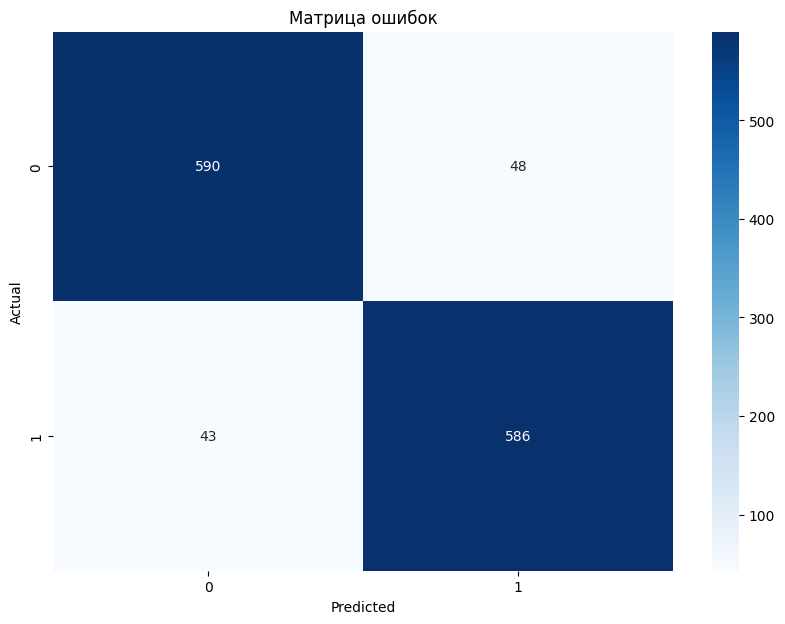

In [60]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Матрица ошибок')
plt.show()

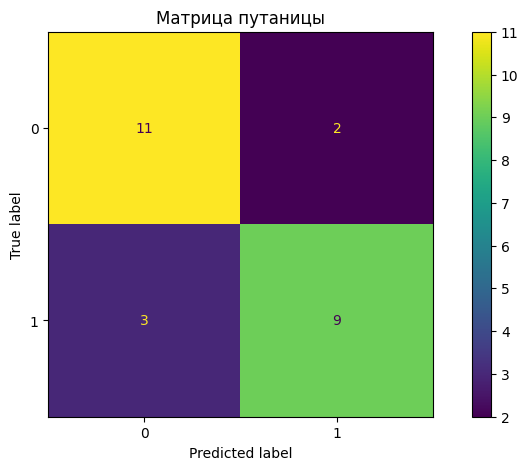

In [61]:
fig, ax = plt.subplots(figsize=(10, 5))
X, y = make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
plt.title('Матрица путаницы')
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)

plt.show()

*Создаем отчет о классификации*

In [ ]:
print('\n clasification report:\n', classification_report(y_test, y_pred))


 clasification report:
               precision    recall  f1-score   support

        FAKE       0.94      0.92      0.93       638
        REAL       0.92      0.94      0.93       629

    accuracy                           0.93      1267
   macro avg       0.93      0.93      0.93      1267
weighted avg       0.93      0.93      0.93      1267



*Прогнозирование с использованием новых данных*

In [ ]:
ii = ['This is a really important question, Lambert says. “I don’t want to be passed along to two or'
'three people,” she says. “I want one person to contact.” There may be specific contact points'
'for different areas, she adds, such as the director of nursing for related questions. However,'
'“I want to know that I can pop into the executive director’s office anytime, ask any question and'
'make any kind of complaint,” she emphasizes. “I want to know that person is available. Because some'
'times, you have to go up to that level.""']

In [ ]:
ii = tfidf_vectorizer.transform(ii)

In [ ]:
y_pred=pac.predict(ii)

In [ ]:
y_pred

array(['REAL'], dtype='<U4')

In [ ]:
ii_2 = ['Teenage footballers listen to the Russian national anthem before a match. Nearby, artists paint Russian President Vladimir Putin’s portrait on a wall during a graffiti festival.'
'Welcome to Burkina Faso, one of the African nations where Russia is boosting its operations to gain influence.'
'Evidence found by the BBC shows that Russia is using media and cultural initiatives to attract African journalists, influencers, and students while spreading misleading information.']

In [ ]:
ii_2 = tfidf_vectorizer.transform(ii_2)

In [ ]:
y_pred=pac.predict(ii_2)

In [ ]:
y_pred

array(['FAKE'], dtype='<U4')